In [ ]:
!for arch in "drive/My Drive/stacks"/*.tar.xz; do tar xvf "$arch"; done

tar: drive/My Drive/stacks/*.tar.xz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
!pip install -Uq ipyfilechooser numba

     |████████████████████████████████| 3.1MB 5.9MB/s 
     |████████████████████████████████| 24.6MB 132kB/s 


This script expects a directory full of directories, each with files named `mask.tif` and `stack_blur.tif`.

In [ ]:
!rm -rvf sample_data
!nvidia-smi
# Commented above + uncommented below: no GPU
# Uncommented above + commented below: have GPU
# %env NUMBA_ENABLE_CUDASIM 1

removed 'sample_data/anscombe.json'
removed 'sample_data/README.md'
removed 'sample_data/mnist_train_small.csv'
removed 'sample_data/mnist_test.csv'
removed 'sample_data/california_housing_train.csv'
removed 'sample_data/california_housing_test.csv'
removed directory 'sample_data'
Wed Nov 18 14:47:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      0MiB / 

Each subdirectory is loaded into a `Stack`, consisting of arrays `data` and `mask`. `stack` is a 3D array that should be considered as a 2D array of pixels, each of which has a 1D time series of values attached. That is, the axes are `(imageY, imageX, frame)`.

In [ ]:
from contextlib import contextmanager
import numba.cuda as nc
from numba.core.config import ENABLE_CUDASIM
from typing import Callable, Optional

if ENABLE_CUDASIM:
  from numba.cuda.simulator.api import stream as Stream
else:
  from numba.cuda.cudadrv.driver import Stream

@contextmanager
def maybeSync(stream: Optional[Stream] = None):
  shouldSync = stream is None
  if shouldSync:
    stream = nc.stream()
  try:
    yield stream
  finally:
    if shouldSync:
      stream.synchronize()

In [ ]:
from dataclasses import InitVar, dataclass, field
import numpy as np

@dataclass(eq = False)
class Stack:
  """An image stack (2D + time) associated with its mask (2D)."""
  data: np.ndarray
  mask: np.ndarray
  bleachPoint: int
  endPoint: int
  frameRate: float
  def __post_init__(self):
    if len(self.data.shape) != 3 or self.mask.shape != self.data.shape[:2]:
      raise ValueError(
          f"Tried to make a Stack with arrays of shape {self.data.shape} and "
            f" {self.mask.shape}")
    if self.bleachPoint not in range(0, self.data.shape[2] + 1):
      raise IndexError(
          f"Bleach point {self.bleachPoint} not within the {self.data.shape[2]}"
            " frames of stack")
    if self.endPoint not in range(0, self.data.shape[2] + 1):
      raise IndexError(
          f"End point {self.endPoint} not within the {self.data.shape[2]}"
            " frames of stack")
    if self.frameRate <= 0:
      raise ValueError(
          f"Attempted to use nonpositive frame rate {self.frameRate}")
    self.data = self.data.astype(np.float64)
    self.mask = self.mask.astype(np.bool_)

In [ ]:
import os
from PIL import Image
from scipy import ndimage
from typing import Generator, Tuple

def loadStack(dataFile: str, maskFile: str) -> Stack:
  dataImage = Image.open(dataFile)
  stack = []
  for i in range(dataImage.n_frames):
    dataImage.seek(i)
    stack.append(np.array(dataImage))
  mask = ndimage.binary_erosion(np.array(Image.open(maskFile)), np.ones((5, 5)))
  # Using 301 as the endpoint reproduces results of the original Mathematica
  # code (selecting 301 - 100 = 201 frames), but the paper says it should be
  # 200 frames selected, with endpoint 300
  return Stack(np.dstack(stack), mask, 100, 300, 10 / 1000)

def loadStacks(
    directory: str, dataName: str = "stack_blur.tif",
    maskName: str = "mask.tif") -> \
    Generator[Tuple[str, Callable[[], Stack]], None, None]:
  with os.scandir(directory) as it:
    for dir in it:
      if dir.is_dir():
        def doLoad(p = dir.path) -> Stack:
          try:
            return loadStack(
                os.path.join(p, dataName), os.path.join(p, maskName))
          except Exception as e:
            raise Exception(
                f"Failed to load stack ({dataName}, {maskName}) from {p}") \
              from e
        yield dir.path, doLoad

In [ ]:
from google.colab import widgets
from ipyfilechooser import FileChooser

chooser = FileChooser(title = "Directory of inputs", use_dir_icons = True)
def loadingCallback(chooser):
  paths, loads = zip(*loadStacks(chooser.selected_path))
  grid = widgets.Grid(len(paths) + 1, 7, header_row = True)
  with grid.output_to(0, 0):
    print("Name")
  with grid.output_to(0, 1):
    print("Width")
  with grid.output_to(0, 2):
    print("Height")
  with grid.output_to(0, 3):
    print("Frames")
  with grid.output_to(0, 4):
    print("Selected Pixels")
  with grid.output_to(0, 5):
    print("Bleach point")
  with grid.output_to(0, 6):
    print("End point")
  for i in range(len(paths)):
    with grid.output_to(i + 1, 0):
      print(os.path.basename(paths[i]))
  for i in range(len(loads)):
    image = loads[i]()
    with grid.output_to(i + 1, 1):
      print(image.data.shape[1])
    with grid.output_to(i + 1, 2):
      print(image.data.shape[0])
    with grid.output_to(i + 1, 3):
      print(image.data.shape[2])
    with grid.output_to(i + 1, 4):
      print(np.count_nonzero(image.mask))
    with grid.output_to(i + 1, 5):
      print(image.bleachPoint)
    with grid.output_to(i + 1, 6):
      print(image.endPoint)
chooser.register_callback(loadingCallback)
display(chooser)

FileChooser(path='/content', filename='', title='HTML(value='Directory of inputs')', show_hidden='False', use_…

,,,,,,
,,,,,,
,,,,,,
,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Name


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Width


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Height


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Frames


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Selected Pixels


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Bleach point


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

End point


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cell2_comp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cell2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

cell6_bin


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

312


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

140


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

400


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5829


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

300


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

312


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

140


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

400


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6278


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

300


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

78


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

409


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

175


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

300


<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following is a framework for performing many parallel least squares fits on the GPU.

In [ ]:
#@title Gaussian elimination
import numba as nb
import numba.cuda as nc

@nc.jit((nb.float64[:, ::1], nb.float64[:, ::1]), device = True)
def solveGaussian(A, b):
  """
  Solve A @ x = b (where A is nxn and x and b are nxm). Returns x in b and
  clobbers A into the identity.
  """
  # Place in row echelon form
  i = 0
  j = 0
  while i < A.shape[0] and j < A.shape[1]:
    if A[i, j] == 0:
      best = i
      for k in range(i, A.shape[0]):
        if abs(A[k, j]) > abs(A[best, j]):
          best = k
      if A[best, j] != 0:
        for k in range(j, A.shape[1]):
          A[i, k], A[best, k] = A[best, k], A[i, k]
        for k in range(b.shape[1]):
          b[i, k], b[best, k] = b[best, k], b[i, k]
    if A[i, j] != 0:
      for k in range(i + 1, A.shape[0]):
        factor = -A[k, j] / A[i, j]
        for l in range(j + 1, A.shape[1]):
          A[k, l] += factor * A[i, l]
        A[k, j] = 0
        for l in range(b.shape[1]):
          b[k, l] += factor * b[i, l]
      i += 1
    j += 1
  # Repair singular matrices by placing 1s along the diagonal
  for j in range(i, A.shape[0]):
    A[j, j] = 1
  # Finally, reduce A to the identity
  for i in range(A.shape[0]):
    i = A.shape[0] - 1 - i
    for j in range(b.shape[1]):
      b[i, j] /= A[i, i]
    A[i, i] = 1
    for j in range(i):
      for k in range(b.shape[1]):
        b[j, k] -= A[j, i] * b[i, k]
      A[j, i] = 0

In [ ]:
#@title Least-squares fit and covariance estimation
def makeFit(n, f, dfdX, bounds = None):
  """
  Create a CUDA device function that performs a least squares fit to the
  function f with n parameters. Both f and dfdX should be device functions
  themselves. f should have signature float64(float64, float64[::1]), and dfdX
  should be void(float64, float64[::1], float[::1]). The first two parameters of
  each are the curve parameter t >= 0 and the fit parameters in an array of
  shape (n,). f should simple return the value of the function, while dfdX
  should return into the final array (provided with shape (n,)) the derivatives
  of f with respect to its parameters (in the same order as the parameters). The
  bounds should be an iterable of pairs of length at least n. The first element
  of each pair is the lower bound for the corresponding parameter, and the
  second is the upper. By default, there are no bounds (they are (-inf, inf) for
  every parameter).

  The resulting function has signature
  float64(float64[::1], float64[::1], float64[::1], float64[:, ::1]). Its first
  parameter is the array of values that need to be fit (of shape (m,) for any
  m), its second is both the initial guess for the parameters and the return
  location for the fit, its third is the return location for the residuals, and
  the fourth is the return location for the approximated Hessian matrix
  (actually J.T @ J, where J is the Jacobian of the residuals) of the objective
  function (of shape (n, n)). The return value is the total R^2 value (the
  minimized sum of the residuals).
  """
  if bounds is None:
    bounds = [(-float("inf"), float("inf"))] * n
  def makeReflector(i, lo, hi):
    @nc.jit((nb.float64[::1],), device = True, inline = True)
    def reflector(params):
      while True:
        if params[i] < lo:
          params[i] = (lo - params[i]) + lo
          continue
        if params[i] > hi:
          params[i] = (hi - params[i]) + hi
          continue
        break
    return reflector
  if ENABLE_CUDASIM:
    reflectors = \
      [makeReflector(i, *bound) for i, bound in zip(range(n), bounds)]
    @nc.jit((nb.float64[::1],), device = True, inline = True)
    def reflector(params):
      for reflector in reflectors:
        reflector(params)
  else:
    @nc.jit((nb.float64[::1],), device = True, inline = True)
    def reflector(_): pass
    for i, bound in zip(range(n), bounds):
      nextReflector = makeReflector(i, *bound)
      @nc.jit((nb.float64[::1],), device = True, inline = True)
      def reflector(params):
        reflector(params)
        nextReflector(params)

  @nc.jit(
    nb.float64(nb.float64[::1], nb.float64[::1], nb.float64[::1]),
    device = True, inline = True)
  def calcResiduals(values, params, residuals):
    R2 = 0
    for t in range(residuals.size):
      residuals[t] = values[t] - f(t, params)
      R2 += residuals[t] * residuals[t]
    return R2

  @nc.jit(
      nb.float64(
          nb.float64[::1], nb.float64[::1], nb.float64[::1],
          nb.float64[:, ::1]),
      device = True)
  def impl(values, params, residuals, hessian):
    # R. Fletcher, A Modified Marquardt Subroutine for Non-Linear Least Squares
    R2 = calcResiduals(values, params, residuals)
    damping = 0
    cutoff = 0
    for i in range(1000):
      # Normal equation:
      # (jac.T @ jac + damping * diag(jac.T @ jac)) @ shift = jac.T @ residuals
      # jac is the negative/positive Jacobian of the residuals/predictions
      # hessian = jac.T @ jac
      # gradient = jac.T @ residuals is the (negative) gradient of the objective
      gradient = nc.local.array(n, nb.float64)
      for i in range(n):
        for j in range(i, n):
          hessian[i, j] = 0
        gradient[i] = 0
      for t in range(values.size):
        derivatives = nc.local.array(n, nb.float64)
        dfdX(t, params, derivatives)
        for i in range(n):
          for j in range(i, n):
            hessian[i, j] += derivatives[i] * derivatives[j]
          gradient[i] += residuals[t] * derivatives[i]
      for i in range(n):
        for j in range(i):
          hessian[i, j] = hessian[j, i]

      newR2 = R2
      while newR2 >= R2:
        dampedMat = nc.local.array((n, n), nb.float64)
        for i in range(n):
          for j in range(n):
            dampedMat[i, j] = hessian[i, j] * 1 + (damping if i == j else 0)

        shift = nc.local.array((n, 1), nb.float64)
        for i in range(n):
          shift[i, 0] = gradient[i]
        solveGaussian(dampedMat, shift)

        size2 = 0
        for i in range(n):
          size2 += shift[i, 0] * shift[i, 0]
        if size2 < 0.000001 * 0.000001:
          break

        attempt = nc.local.array(n, nb.float64)
        for i in range(n):
          attempt[i] = params[i] + shift[i, 0]
        reflector(attempt)

        newR2 = calcResiduals(values, attempt, residuals)
        # Predicted reduction:
        # 2 * shift.T @ gradient - shift.T @ hessian @ shift
        red = 0
        for i in range(n):
          red += shift[i, 0] * gradient[i]
        red *= 2
        for i in range(n):
          right = 0
          for j in range(n):
            right += hessian[i, j] * shift[j, 0]
          red -= shift[i, 0] * right

        if (R2 - newR2) / red > 0.75:
          damping /= 2
          if damping < cutoff:
            damping = 0
        elif (R2 - newR2) / red < 0.25:
          alignment = 0
          for i in range(n):
            alignment += shift[i, 0] * gradient[i]
          factor = 2 - (newR2 - R2) / alignment
          if factor < 2:
            factor = 2
          elif factor > 10:
            factor = 10

          if damping == 0:
            # damping = tr(hessian^-1)
            for i in range(n):
              for j in range(n):
                dampedMat[i, j] = hessian[i, j]
            inverted = nc.local.array((n, n), nb.float64)
            for i in range(n):
              for j in range(n):
                inverted[i, j] = 1 if i == j else 0
            solveGaussian(dampedMat, inverted)
            for i in range(n):
              damping += inverted[i, i]
            cutoff = damping
            factor /= 2

          damping *= factor
      else:
        for i in range(n):
          params[i] = attempt[i]
        R2 = newR2
        continue
      break

    return R2

  return impl

def makeFitCovariance(n, d2fdX2):
  """
  Create a CUDA device function that can take the residual vector and
  approximate Hessian matrix left behind by a makeFit kernel, complete the
  Hessian with the second derivative of the fit function, and calculate the
  covariance matrix of the fit. n must be the number of parameters, as with
  makeFit, and d2fdX2 must be a device function of signature
  void(float64, float64[::1], float64[:, ::1]). The first parameters are
  respectively the curve parameter t >= 0 and the fit parameters, in a array of
  shape (n,). It should return all of the second derivatives of the fit function
  with respect to its parameters (in the corresponding positions) in the final
  parameter, which will be an (n, n) matrix. Since this matrix should be
  symmetric, only the upper half (main diagonal and above) needs to be filled
  in; the lower half will not be used.

  The resulting kernel has signature
  void(float64[::1], float64, float64[::1], float64[:, ::1]). The first
  parameter is the array of fit parameters, the second is the total R^2 value,
  and the third is the array of residuals. (The second parameter should be the
  sum of the third parameter.) The fourth is both the input for the approximate
  Hessian and the output for the covariance matrix.
  """

  @nc.jit(
      (nb.float64[::1], nb.float64, nb.float64[::1], nb.float64[:, ::1]),
      device = True)
  def impl(params, R2, residuals, covariance):
    # Shuffle the input out of the output
    hessian = nc.local.array((n, n), nb.float64)
    for i in range(n):
      for j in range(n):
        hessian[i, j] = covariance[i, j]
    # Complete the Hessian (of the objective):
    # Using this *should* be better, but it's apparently not!
    # hessian -= sum_i(residuals[i] * HR[i])
    # HR[i, j, k] = d^2[f(i; X)]/(dx_j dx_k)
    correction = nc.local.array((n, n), nb.float64)
    for t in range(residuals.size):
      # Reusing covariance as partial correction
      d2fdX2(t, params, covariance)
      for i in range(n):
        for j in range(i, n):
          correction[i, j] -= residuals[t] * covariance[i, j]
    corrected = nc.local.array((n, n), nb.float64)
    for i in range(n):
      for j in range(i, n):
        corrected[i, j] = corrected[j, i] = hessian[i, j] + correction[i, j]
    # The covariance matrix is specified by hessian @ covariance = variance * I,
    # which can be solved by solveGaussian
    variance = R2 / (residuals.size - n)
    for i in range(n):
      for j in range(n):
        covariance[i, j] = variance if i == j else 0
    solveGaussian(corrected, covariance)
    # Sometimes (I don't know why, really), the corrected Hessian is worse than
    # the real one
    # Detect this situation by looking for negatives along the diagonal.
    for i in range(n):
      if covariance[i, i] < 0:
        # Save our current result in case the other one is also bad
        for i in range(n):
          for j in range(i, n):
            corrected[i, j] = covariance[i, j]
        for i in range(n):
          for j in range(n):
            covariance[i, j] = variance if i == j else 0
        solveGaussian(hessian, covariance)
        for i in range(n):
          if covariance[i, i] < 0:
            # Give up...
            for j in range(n):
              for k in range(j, n):
                covariance[j, k] = covariance[k, j] = corrected[j, k]
            break
        break
  
  return impl

One processing pipeline involves splitting the data into "before bleaching" and "after bleaching". Then a fit to the before part can be used to estimate and correct the acquisition photobleaching in the after part. The following is the "before bleaching" fit.

In [ ]:
#@title Bleaching fit kernel
from math import exp

def makeFitBleaching():
  @nc.jit(nb.float64(nb.float64, nb.float64[::1]), device = True, inline = True)
  def f(t, params):
    # f(t; A, B, C) = A exp(-t/B) + C
    return params[0] * exp(-t / params[1]) + params[2]
  @nc.jit(
      (nb.float64, nb.float64[::1], nb.float64[::1]), device = True,
      inline = True)
  def dfdX(t, params, dfdXs):
    # d[f(t; A, B, C)]/dA = exp(-t/B)
    # d[f(t; A, B, C)]/dB = A B^-2 t exp(-t/B)
    # d[f(t; A, B, C)]/dC = 1
    dfdXs[0] = exp(-t / params[1])
    dfdXs[1] = params[0] * t * exp(-t / params[1]) / (params[1] * params[1])
    dfdXs[2] = 1
  doFit = makeFit(3, f, dfdX, bounds = [(0, float("inf"))] * 3)
  @nc.jit(
      (nb.float64[:, :, ::1], nb.boolean[:, ::1], nb.float64[:, :, ::1],
       nb.float64[:, :, ::1]))
  def fitBleaching(stack, mask, paramss, residualss):
    """
    Fit to f(t; A, B, C) = A exp(-t/B) + C. The t-values are 0, 1, ... and the
    values f(t) are taken in the array stack[pos]. paramss is the return
    location: the 3 fit parameters are written to paramss[i, j]. residualss is
    scratch space of the same shape as stack.
    """
    pos = nc.grid(2)
    if pos[0] >= mask.shape[0] or pos[1] >= mask.shape[1]:
      pass
    elif not mask[pos]:
      for i in range(paramss.shape[2]):
        paramss[pos][i] = 0
    else:
      paramss[pos][0] = 2 * (stack[pos][0] - stack[pos][stack.shape[2] - 1])
      paramss[pos][1] = stack.shape[2]
      paramss[pos][2] = stack[pos][0]
      hessian = nc.local.array((3, 3), nb.float64)
      doFit(stack[pos], paramss[pos], residualss[pos], hessian)

  return fitBleaching

fitBleaching = makeFitBleaching()
del makeFitBleaching

And these are the two options for the correction.

In [ ]:
#@title Using the average of each frame
from math import expm1
if ENABLE_CUDASIM:
  from numba.cuda.simulator.cudadrv.devicearray import \
    FakeCUDAArray as DeviceNDArray
else:
  from numba.cuda.cudadrv.devicearray import DeviceNDArray

def makeCorrectOverall():
  @nc.jit((nb.float64[:, :, ::1], nb.boolean[:, ::1], nb.float64[::1]))
  def calcMeans(stack, mask, means):
    pos = nc.grid(1)
    if pos < stack.shape[2]:
      means[pos] = 0
      nmask = 0
      for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
          if mask[i, j]:
            means[pos] += stack[i, j, pos]
            nmask += 1
      means[pos] /= nmask
  @nc.jit(
      (nb.float64[:, :, ::1], nb.boolean[:, ::1], nb.int64, nb.float64[::1]))
  def correct(stack, mask, off, params):
    pos = nc.grid(3)
    if pos[0] < stack.shape[0] and pos[1] < stack.shape[1] and \
        pos[2] < stack.shape[2] and mask[pos[:2]]:
      stack[pos] -= params[0] * expm1(-(pos[2] + off) / params[1])

  def correctOverall(
      pre: DeviceNDArray, post: DeviceNDArray, mask: DeviceNDArray,
      stream: Optional[Stream] = None) -> None:
    with maybeSync(stream) as stream:
      overalls = nc.device_array(pre.shape[2], np.float64, stream = stream)
      blockSize = 512
      calcMeans \
        [-(-pre.shape[2] // blockSize), blockSize, stream] \
        (pre, mask, overalls)
      params = nc.device_array(3, np.float64, stream = stream)
      fitBleaching \
        [(1, 1), (1, 1), stream] \
        (overalls.reshape(1, 1, pre.shape[2]),
        nc.to_device(np.array([[True]]), stream = stream),
        params.reshape(1, 1, 3),
        nc.device_array((1, 1, pre.shape[2]), stream = stream))
      blockSize = (8, 8, 8)
      gridSize = tuple(-(-d // b) for d, b in zip(post.shape, blockSize))
      correct[gridSize, blockSize, stream](post, mask, pre.shape[2], params)

  return correctOverall

correctOverall = makeCorrectOverall()
del makeCorrectOverall

In [ ]:
#@title Using the values of each pixel

# Note: this doesn't work very well: the data is just too noisy
# Even when the fit doesn't loop forever the error bars are huge
def makeCorrectEach():
  @nc.jit(
      (nb.float64[:, :, ::1], nb.boolean[:, ::1], nb.int64,
       nb.float64[:, :, ::1]))
  def correct(stack, mask, off, paramss):
    pos = nc.grid(3)
    if pos[0] < stack.shape[0] and pos[1] < stack.shape[1] and \
        pos[2] < stack.shape[2] and mask[pos[:2]]:
      params = paramss[pos[:2]]
      stack[pos] -= params[0] * expm1(-(pos[2] + off) / params[1])

  def correctEach(
      pre: DeviceNDArray, post: DeviceNDArray, mask: DeviceNDArray,
      stream: Optional[Stream] = None) -> None:
    with maybeSync(stream) as stream:
      blockSize = (19, 19)
      gridSize = tuple(-(-d // b) for d, b in zip(mask.shape, blockSize))
      paramss = nc.device_array(mask.shape + (3,), np.float64, stream = stream)
      fitBleaching \
        [gridSize, blockSize, stream] \
        (pre, mask, paramss, nc.device_array_like(pre, stream = stream))
      blockSize = (8, 8, 8)
      gridSize = tuple(-(-d // b) for d, b in zip(post.shape, blockSize))
      correct[gridSize, blockSize, stream](post, mask, pre.shape[2], paramss)

  return correctEach

correctEach = makeCorrectEach()
del makeCorrectEach

These are the "after bleaching" fits.

In [ ]:
#@title After-bleaching fits

class SelfAllocatingBleachFit:
  __slots__ = ["underlying", "n"]
  def __init__(self, underlying, n):
    self.underlying = underlying
    self.n = n
  def __getitem__(self, args):
    n = self.n
    underlying = self.underlying[args]
    argStream = args[2] if len(args) > 2 else None
    def ret(data, mask):
      with maybeSync(argStream) as stream:
        paramss = \
          nc.device_array(data.shape[:2] + (n,), np.float64, stream = stream)
        residualss = nc.device_array_like(data, stream)
        R2s = nc.device_array(data.shape[:2], np.float64, stream = stream)
        covariances = \
          nc.device_array(data.shape[:2] + (n, n), np.float64, stream = stream)
        underlying(data, mask, paramss, residualss, R2s, covariances)
        return paramss, residualss, R2s, covariances
    return ret

def makeBleachedFit(n, f, dfdX, d2fdX2, guess, bounds = None):
  if bounds is None:
    bounds = [(0, np.inf)] * n
  doFit = makeFit(n, f, dfdX, bounds)
  calcCov = makeFitCovariance(n, d2fdX2)
  @nc.jit((
      nb.float64[:, :, ::1], nb.boolean[:, ::1], nb.float64[:, :, ::1],
      nb.float64[:, :, ::1], nb.float64[:, ::1], nb.float64[:, :, :, ::1]))
  def fitRecovery(stack, mask, paramss, residualss, R2s, covariances):
    """
    The t-values are 0, 1, ... and the values f(t) are taken in the array
    stack[i, j]. If !mask[i, j], no fit is done, and dummy values are written to
    the output. The following parameters are the return locations, where the fit
    parameters (paramss[i, j, :n]), the residuals (residualss[i, j]), the total
    R^2 value (R2s[i, j]), and the covariance matrix (covariances[i, j, :n, :n])
    are stored.
    """
    pos = nc.grid(2)
    if pos[0] >= mask.shape[0] or pos[1] >= mask.shape[1]:
      pass
    elif not mask[pos]:
      for i in range(n):
        for j in range(n):
          covariances[pos][i, j] = 0
        paramss[pos][i] = 0
      for i in range(residualss.shape[2]):
        residualss[pos][i] = 0
      R2s[pos] = 0
    else:
      guess(stack[pos], paramss[pos])
      R2s[pos] = \
        doFit(stack[pos], paramss[pos], residualss[pos], covariances[pos])
      calcCov(paramss[pos], R2s[pos], residualss[pos], covariances[pos])

  return SelfAllocatingBleachFit(fitRecovery, n)

In [ ]:
#@title Recovery fit kernel

def makeFitRecovery():
  @nc.jit(nb.float64(nb.float64, nb.float64[::1]), device = True, inline = True)
  def f(t, params):
    # f(t; A, B, C) = A(1 - exp(-t/B)) + C
    return params[0] * -expm1(-t / params[1]) + params[2]
  @nc.jit(
      (nb.float64, nb.float64[::1], nb.float64[::1]), device = True,
      inline = True)
  def dfdX(t, params, dfdXs):
    # d[f(t; A, B, C)]/dA = 1 - exp(-t/B)
    # d[f(t; A, B, C)]/dB = - A B^-2 t exp(-t/B)
    # d[f(t; A, B, C)]/dC = 1
    dfdXs[0] = -expm1(-t / params[1])
    dfdXs[1] = -params[0] * t * exp(-t / params[1]) / (params[1] * params[1])
    dfdXs[2] = 1
  @nc.jit(
      (nb.float64, nb.float64[::1], nb.float64[:, ::1]), device = True,
      inline = True)
  def d2fdX2(t, params, d2fdX2s):
    # d^2[f(t; A, B, C)]/(dA dB) = -B^-2 t exp(-t/B)
    # d^2[f(t; A, B, C)]/(dB dB) = A exp(-t/B) (2B - t) t B^-4
    for i in range(3):
      for j in range(i, 3):
        d2fdX2s[i, j] = 0
    d2fdX2s[0, 1] = -exp(-t / params[1]) * t / (params[1] * params[1])
    d2fdX2s[1, 1] = \
      params[0] * exp(-t / params[1]) * (2 * params[1] - t) * t \
      / pow(params[1], 4)
  @nc.jit((nb.float64[::1], nb.float64[::1]), device = True, inline = True)
  def guess(values, params):
      params[0] = values[0]
      params[1] = values.size / 3
      params[2] = values[0]
  return makeBleachedFit(
      3, f, dfdX, d2fdX2, guess, [(0, np.inf), (0, np.inf), (-np.inf, np.inf)])

fitRecovery = makeFitRecovery()
del makeFitRecovery

In [ ]:
#@title Acquisition-Bleaching Recovery fit kernel

# def makeFitAcqRecovery():
#   @nc.jit(nb.float64(nb.float64, nb.float64[::1]), device = True, inline = True)
#   def f(t, params):
#     # f(t; A, B, C, D, E) = A(1 - exp(-t/B))(C + Dexp(-t/E))
#     acq = params[2] + params[3] * exp(-t / params[4])
#     return params[0] * -expm1(-t / params[1]) * acq
#   @nc.jit(
#       (nb.float64, nb.float64[::1], nb.float64[::1]), device = True,
#       inline = True)
#   def dfdX(t, params, dfdXs):
#     # d[f(t; A, B, C, D, E)]/dA = (1 - exp(-t/B)) * (C + Dexp(-t/E))
#     # d[f(t; A, B, C, D, E)]/dB = - A B^-2 t exp(-t/B) (C + Dexp(-t/E))
#     # d[f(t; A, B, C, D, E)]/dC = A(1 - exp(-t/B))
#     # d[f(t; A, B, C, D, E)]/dD = Aexp(-t/E)(1 - exp(-t/B))
#     # d[f(t; A, B, C, D, E)]/dE = A exp(-t/E) (1 - exp(-t /B)) D t E^-2
#     rec = -expm1(-t / params[1])
#     acq = params[2] + params[3] * exp(-t / params[4])
#     dfdXs[0] = rec * acq
#     dfdXs[1] = \
#       -params[0] * t * exp(-t / params[1]) * acq / (params[1] * params[1])
#     dfdXs[2] = params[0] * rec
#     dfdXs[3] = params[0] * exp(-t / params[4]) * rec
#     dfdXs[4] = \
#       params[0] * exp(-t / params[4]) * rec * params[3] * t \
#       / (params[4] * params[4])
#   @nc.jit(
#       (nb.float64, nb.float64[::1], nb.float64[:, ::1]), device = True,
#       inline = True)
#   def d2fdX2(t, params, d2fdX2s):
#     # d^2[f(t; A, B, C, D, E)]/(dAdA) = 0
#     # d^2[f(t; A, B, C, D, E)]/(dAdB) = - exp(-t/B) (C + Dexp(-t/E)) t B^-2
#     # d^2[f(t; A, B, C, D, E)]/(dAdC) = 1 - exp(-t / B)
#     # d^2[f(t; A, B, C, D, E)]/(dAdD) = exp(-t/E)(1 - exp(-t/B))
#     # d^2[f(t; A, B, C, D, E)]/(dAdE) = D exp(-t/E) (1 - exp(-t/B)) t E^-2
#     # d^2[f(t; A, B, C, D, E)]/(dBdB) =
#     #   (2 A exp(-t/B) (C + Dexp(-t/E)) t  ) B^-3
#     # - (  A exp(-t/B) (C + Dexp(-t/E)) t^2) B^-4
#     # d^2[f(t; A, B, C, D, E)]/(dBdC) = - A exp(-t/B) t B^-2
#     # d^2[f(t; A, B, C, D, E)]/(dBdD) = - A exp(-t/B - t/E) t B^-2
#     # d^2[f(t; A, B, C, D, E)]/(dBdE) = - A D exp(-t/B - t/E) t^2 B^-2 E^-2
#     # d^2[f(t; A, B, C, D, E)]/(dCdC) = 0
#     # d^2[f(t; A, B, C, D, E)]/(dCdD) = 0
#     # d^2[f(t; A, B, C, D, E)]/(dCdE) = 0
#     # d^2[f(t; A, B, C, D, E)]/(dDdD) = 0
#     # d^2[f(t; A, B, C, D, E)]/(dDdE) = A exp(-t/E) (1 - exp(-t/B)) t E^-2
#     # d^2[f(t; A, B, C, D, E)]/(dEdE) = A exp(-t/E) (1 - exp(-t/B)) t E^-2
#     # d^2[f(t; A, B, C, D, E)]/(dEdE) =
#     #   (  A D exp(-t/E) (1 - exp(-t/B)) t^2) E^-4
#     # - (2 A D exp(-t/E) (1 - exp(-t/B)) t  ) E^-3
#     rec = -expm1(-t / params[1])
#     acq = params[2] + params[3] * exp(-t / params[4])
#     d2fdX2s[0, 0] = 0
#     d2fdX2s[0, 1] = -exp(-t / params[1]) * acq * t / (params[1] * params[1])
#     d2fdX2s[0, 2] = rec
#     d2fdX2s[0, 3] = exp(-t / params[4]) * rec
#     d2fdX2s[0, 4] = \
#       params[3] * exp(-t / params[4]) * rec * t / (params[4] * params[4])
#     base = params[0] * exp(-t / params[1]) * acq * t / pow(params[1], 3)
#     d2fdX2s[1, 1] = 2 * base - base * t / params[1]
#     d2fdX2s[1, 2] = \
#       -params[0] * exp(-t / params[1]) * t / (params[1] * params[1])
#     d2fdX2s[1, 3] = \
#       -params[0] * exp(-t / params[1] - t/params[4]) * t \
#       / (params[1] * params[1])
#     d2fdX2s[1, 4] = d2fdX2s[1, 3] * params[3] * t / (params[4] * params[4])
#     d2fdX2s[2, 2] = 0
#     d2fdX2s[2, 3] = 0
#     d2fdX2s[2, 4] = 0
#     d2fdX2s[3, 3] = 0
#     d2fdX2s[3, 4] = \
#       params[0] * exp(-t / params[4]) * rec * t / (params[4] * params[4])
#     base = \
#       params[1] * params[3] * exp(-t / params[4]) * rec * t / pow(params[4], 3)
#     d2fdX2s[4, 4] = base * t / params[4] - 2 * base
#   @nc.jit((nb.float64[::1], nb.float64[::1]), device = True, inline = True)
#   def guess(values, params):
#       params[0] = values.size / 10
#       params[1] = values.size / 20
#       params[2] = values.size / 10
#       params[3] = values[0]
#       params[4] = values.size / 100
#   return makeBleachedFit(5, f, dfdX, d2fdX2, guess)

# fitAcqRecovery = makeFitAcqRecovery()
# del makeFitAcqRecovery

In [ ]:
from math import sqrt
from typing import Tuple

@nc.require_context
def doTest(stack: Stack, idx, stream: Optional[Stream] = None) -> \
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    with maybeSync(stream) as stream:
      pre = nc.to_device(
          np.ascontiguousarray(stack.data[:, :, :stack.bleachPoint]), stream)
      post = nc.to_device(
          np.ascontiguousarray \
            (stack.data[:, :, stack.bleachPoint:stack.endPoint]),
          stream)
      mask = nc.to_device(stack.mask, stream)
      correctOverall(pre, post, mask, stream)
      data = post[idx].reshape((1, 1) + post.shape[2:])
      mask = nc.to_device(np.array([[True]]), stream)
      ret = fitRecovery[(1, 1), (2, 2), stream](data, mask)
      paramss, residualss, R2s, covariances = \
        map(lambda a: a.copy_to_host(stream = stream), ret)
      return paramss[0, 0], residualss[0, 0], R2s[0, 0, None], covariances[0, 0]

# image = loadStack(
#     "samples/sample_rot0/stack_blur.tif", "samples/sample_rot0/mask.tif")
# %timeit doTest(image)
# params, res, R2, cov = doTest(image)
# display(params, res[:10], R2[0], cov)
# del params, res, R2, cov, image, doTest

In [ ]:
from typing import Optional, Tuple
from math import sqrt
from numba.cuda.cudadrv.driver import Stream

@nc.require_context
def doFits(stack: Stack, stream: Optional[Stream] = None) -> \
    Tuple[
          np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray,
          np.ndarray]:
  with maybeSync(stream) as stream:
    pre = nc.to_device(
        np.ascontiguousarray(stack.data[:, :, :stack.bleachPoint]), stream)
    post = nc.to_device(
        np.ascontiguousarray \
          (stack.data[:, :, stack.bleachPoint:stack.endPoint]),
        stream)
    mask = nc.to_device(stack.mask, stream)
    correctOverall(pre, post, mask, stream)
    blockSize = (16, 16)
    gridSize = tuple(-(-d // b) for d, b in zip(mask.shape, blockSize))
    ret = fitRecovery[gridSize, blockSize, stream](post, mask)
    return tuple(map(lambda a: a.copy_to_host(stream = stream), ret))

# image = loadStack(
#     "samples/sample_rot0/stack_blur.tif", "samples/sample_rot0/mask.tif")
# %timeit doFits(image)
# paramss, residualss, R2s, covariances = doFits(image)
# idx = (45, 99)
# display(paramss[idx], R2s[idx], covariances[idx], sqrt(covariances[idx][1, 1]))
# del idx, paramss, residualss, R2s, covariances, image

In [ ]:
# image = loadStack(
#     "NLS-GFP/cell0/stack_blur.tif", "NLS-GFP/cell0/mask.tif")
# # %timeit doTest(image)
# plot.plot(image.data[78, 63])
# plot.show()
# idx = (78, 63)
# params, res, R2, cov = doTest(image, idx)
# display(params, res[:10], R2[0], cov)
# # paramss, ress, R2s, covs = doFits(image)
# # display(paramss[idx], ress[idx][:10], R2s[idx], covs[idx])
# # del paramss, ress, R2s, covs, params, res, R2, cov, idx, image

FileChooser(path='/content', filename='', title='HTML(value='Directory of input stacks/output dirs')', show_hi…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Full result


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clamped (to 99th percentile)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Recovery Level


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

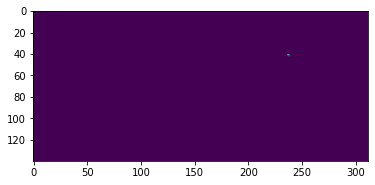

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

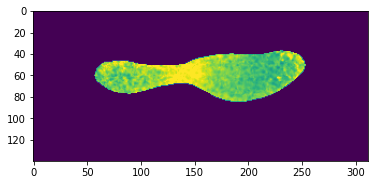

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Recovery Timescale


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

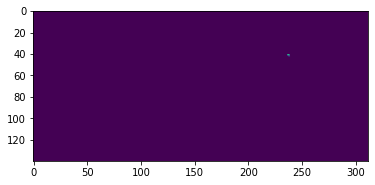

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

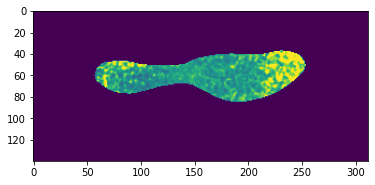

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Rec. Time. Error


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

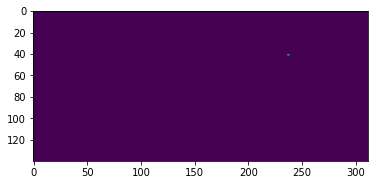

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

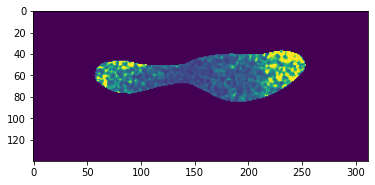

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Full result


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clamped (to 99th percentile)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Recovery Level


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

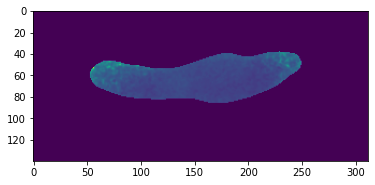

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

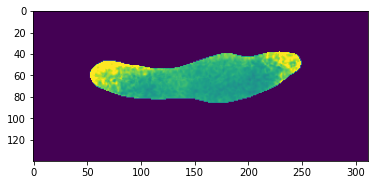

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Recovery Timescale


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

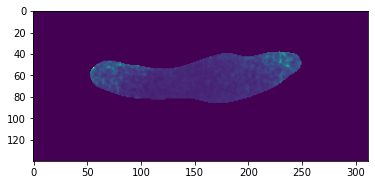

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

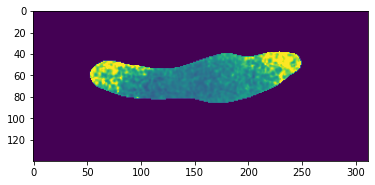

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Rec. Time. Error


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

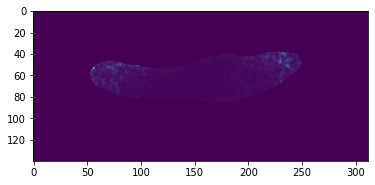

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

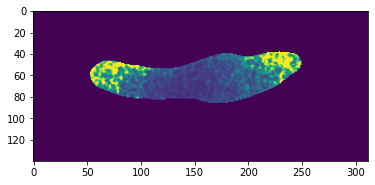

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Full result


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clamped (to 99th percentile)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Recovery Level


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

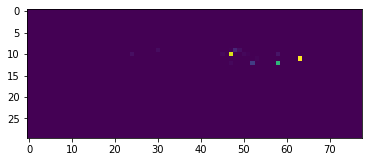

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

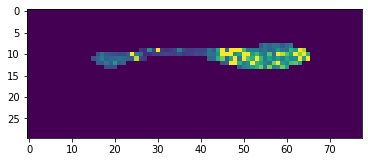

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Recovery Timescale


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

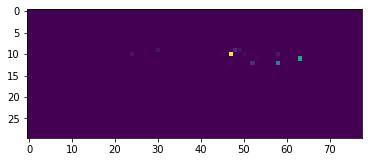

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

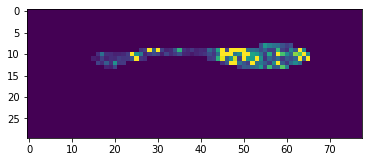

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Rec. Time. Error


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

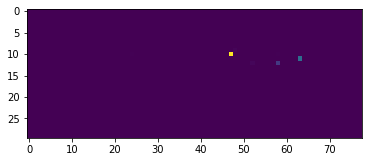

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

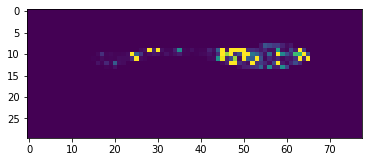

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab.widgets import Grid, TabBar
from IPython.display import clear_output
from ipywidgets import Output
from matplotlib import pyplot as plot

chooser = FileChooser(
    title = "Directory of input stacks/output dirs", use_dir_icons = True)
def callback(chooser):
  paths, loads = zip(*loadStacks(chooser.selected_path))
  names = list(map(os.path.basename, paths))
  tabs = TabBar(names)
  for path, name, load in zip(paths, names, loads):
    with tabs.output_to(name):
      stack = load()
      paramss, _, _, covariances = doFits(stack)
      recoveries = paramss[:, :, 0]
      recoveries /= \
        np.average(stack.data[:, :, :stack.bleachPoint], 2) \
        - np.amin(stack.data, 2)
      times = paramss[:, :, 1]
      times *= stack.frameRate
      timeErrors = covariances[:, :, 1, 1]
      np.sqrt(timeErrors, timeErrors)
      timeErrors *= stack.frameRate
      grid = Grid(4, 3, header_column = True, header_row = True)
      with grid.output_to(0, 1):
        print("Full result")
      with grid.output_to(0, 2):
        print("Clamped (to 99th percentile)")
      def displayAndSave(i, title, filename, arr):
        with grid.output_to(i, 0):
          print(title)
        with grid.output_to(i, 1):
          plot.imshow(arr)
          np.savetxt(os.path.join(path, filename), arr, "%.18f", ",", "\r\n")
        with grid.output_to(i, 2):
          top = np.percentile(arr, 99)
          plot.imshow(np.clip(arr, None, top, out = arr))
      displayAndSave(1, "Recovery Level", "recoveryMap1pixBlur.csv", recoveries)
      displayAndSave(2, "Recovery Timescale", "timeMap1pixBlur.csv", times)
      displayAndSave(
          3, "Rec. Time. Error", "timeErrorMap1pixBlur.csv", timeErrors)
chooser.register_callback(callback)
del callback
display(chooser)

In [ ]:
%%bash
for arch in "drive/My Drive/stacks"/*.tar.xz; do
  dir="${arch##*/}"
  dir="${dir%.tar.xz}"
  [[ -d $dir ]] || continue
  find "$dir" -name "*.csv" -print0 \
    | tar --null -T - -cv | xz -9e > "$dir.tar.xz"
done